In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', help='cifar10 | lsun | imagenet | folder | lfw ')
parser.add_argument('--dataroot', help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--num_classes', type=int, default=4, help="class to generate")
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nc', type=int, default=3, help='input depth')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--cond', action='store_true', help='conditional training')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')


opt = parser.parse_args("")
opt.dataset='folder'
opt.dataroot='./dataset/hand_crafted_aug'
opt.cuda=True  # change to False if running on cpu
opt.cond=True  # enable conditional training
opt.ngpu=4     #change to 1 if running on cpu
opt.niter=20
print(opt)


Namespace(batchSize=64, beta1=0.5, cond=True, cuda=True, dataroot='./dataset/hand_crafted_aug', dataset='folder', imageSize=64, lr=0.0002, manualSeed=None, nc=3, ndf=64, netD='', netG='', ngf=64, ngpu=4, niter=20, num_classes=4, nz=100, outf='.', workers=2)


In [21]:
try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

if opt.dataset in ['imagenet', 'folder', 'lfw']:
    # folder dataset
    dataset = dset.ImageFolder(root=opt.dataroot,
                               transform=transforms.Compose([
                                   transforms.Scale(opt.imageSize),
                                   #transforms.CenterCrop(opt.imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
elif opt.dataset == 'lsun':
    dataset = dset.LSUN(db_path=opt.dataroot, classes=['bedroom_train'],
                        transform=transforms.Compose([
                            transforms.Scale(opt.imageSize),
                            transforms.CenterCrop(opt.imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
elif opt.dataset == 'cifar10':
    dataset = dset.CIFAR10(root=opt.dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Scale(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    )
elif opt.dataset == 'mnist':
    dataset = dset.MNIST(root=opt.dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Scale(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    )

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = int(opt.nc)
ncc = nc  
nzc = nz

num_classes = opt.num_classes

if opt.cond:
    ncc = nc + num_classes
    nzc = nz + num_classes

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nzc, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      ncc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (ncc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = _netG(ngpu)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (ncc) x 64 x 64
            nn.Conv2d(ncc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1)


netD = _netD(ngpu)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

criterion = nn.BCELoss()

input = torch.FloatTensor(opt.batchSize, 3, opt.imageSize, opt.imageSize)
noise = torch.FloatTensor(opt.batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(opt.batchSize)
real_label = 1
fake_label = 0

import sys


fixed_class = 3

def one_hot(target):
    # One hot encoding buffer that you create out of the loop and just keep reusing
    target_onehot = torch.FloatTensor(target.size(0), num_classes)
    
    #target_onehot = torch.FloatTensor(opt.batchSize, num_classes)
    # In your for loop
    target_onehot.zero_()
    target_onehot.scatter_(1, target, 1)
    if opt.cuda:
        target_onehot = target_onehot.cuda()
    return target_onehot    


if opt.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

if opt.cond:
    ones = torch.ones(opt.batchSize,1)
    fixed_class_vec = torch.mul(ones,fixed_class)
    #print (fixed_class_vec)
    class_onehot = one_hot(fixed_class_vec.long())
    class_onehot.unsqueeze_(2).unsqueeze_(3)

    fixed_noise = torch.cat([fixed_noise,class_onehot],1)
    #print (fixed_noise)



input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)


# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

def one_hot_image_exrta_layers(target):
    batch_size = target.size(0)
    target_hot = one_hot(target.unsqueeze(1))
    #print (target)
    #print (target_hot)
    repeat1 = target_hot.repeat(1,64)
    repeat2 = repeat1.view(batch_size,64,num_classes)
    repeat3 =repeat2.repeat(1,64,1)
    repeat4 = repeat3.view(batch_size,64,64,num_classes)
    repeat5 = repeat4.permute(0,3,2,1)
    if opt.cuda:
        repeat5 = repeat5.cuda()
    return repeat5    



Random Seed:  2466
_netG (
  (main): Sequential (
    (0): ConvTranspose2d(104, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 7, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)
_netD (
  (main): Sequential (
    (0): Conv2d(7, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [22]:
#errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2
loss_d_history = []
loss_g_history = []
d_x_history = []
d_g_z1_history = []
d_g_z2__history = []

In [23]:
for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, target = data
        if opt.cuda:
            real_cpu = real_cpu.cuda()
        batch_size = real_cpu.size(0)

        one_hot_target_layers = None
        bs = target.size(0)

        real_cpu_with_targets = real_cpu
        if opt.cond:
            one_hot_target_layers = one_hot_image_exrta_layers(target)
            real_cpu_with_targets = torch.cat([real_cpu,one_hot_target_layers],1)
            

        input.data.resize_(real_cpu_with_targets.size()).copy_(real_cpu_with_targets)
        label.data.resize_(batch_size).fill_(real_label)

        output = netD(input)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.data.resize_(batch_size, nz, 1, 1)
        noise.data.normal_(0, 1)

        if opt.cond:
            noise_data = noise.data
            target_onehot = one_hot(target.unsqueeze(1))
            target_onehot.unsqueeze_(2).unsqueeze_(3)
            #print (target_onehot)
            #print (noise_data)
            noise_data_with_target = torch.cat([noise_data,target_onehot],1)
            noise.data.resize_(batch_size, nzc, 1, 1)
            noise.data.copy_(noise_data_with_target)
            #print (noise_data_with_target)
            #sys.exit()

        fake = netG(noise)

        if opt.cond:
            #add condition to fake output
            zeros = torch.zeros(bs,opt.nc,64,64)
            if opt.cuda:
                zeros = zeros.cuda()
            zeros_with_target = torch.cat([zeros,one_hot_target_layers],1)
            #print (target9)
            zeros_with_target_var = Variable(zeros_with_target)
            fake = fake.add(zeros_with_target_var)
            #print (fake)
            #sys.exit()
            # fake_data = torch.cat([fake.data,target5],1)
            # fake.data.resize_(fake_data.size()).copy_(fake_data)

        label.data.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.data.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        loss_d_history.append(errD.data[0])
        loss_g_history.append(errG.data[0])
        d_x_history.append(D_x)
        d_g_z1_history.append(D_G_z1)
        d_g_z2__history.append(D_G_z2)
        #training_loss_history.append(trn_loss)
        if i % 100 == 0:
            #print (target)
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            fake2 = fake.data
            if opt.cond:
                #print (fake)
                fake2 = fake.data[:,0:opt.nc,:,:]
                # if opt.nc == 1:
                #     fake2 = fake2.unsqueeze(1)
                #print (fake2)
                #print (fake2)
            vutils.save_image(fake2,
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)

    # do checkpointing
    #torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    #torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

[0/20][0/157] Loss_D: 1.9921 Loss_G: 1.8165 D(x): 0.2956 D(G(z)): 0.4043 / 0.4309
[0/20][1/157] Loss_D: 2.5847 Loss_G: 3.3782 D(x): 0.8435 D(G(z)): 0.7456 / 0.1316
[0/20][2/157] Loss_D: 1.3262 Loss_G: 4.7888 D(x): 0.7954 D(G(z)): 0.4853 / 0.0269
[0/20][3/157] Loss_D: 0.8176 Loss_G: 3.9551 D(x): 0.6187 D(G(z)): 0.1693 / 0.0287
[0/20][4/157] Loss_D: 0.7089 Loss_G: 3.7004 D(x): 0.7375 D(G(z)): 0.2100 / 0.0573
[0/20][5/157] Loss_D: 0.9085 Loss_G: 4.2723 D(x): 0.8066 D(G(z)): 0.3850 / 0.0231
[0/20][6/157] Loss_D: 0.5143 Loss_G: 4.9065 D(x): 0.8197 D(G(z)): 0.1799 / 0.0103
[0/20][7/157] Loss_D: 0.3097 Loss_G: 4.5927 D(x): 0.8768 D(G(z)): 0.1375 / 0.0184
[0/20][8/157] Loss_D: 0.4485 Loss_G: 4.1100 D(x): 0.8130 D(G(z)): 0.1531 / 0.0272
[0/20][9/157] Loss_D: 0.3817 Loss_G: 4.8154 D(x): 0.8959 D(G(z)): 0.1882 / 0.0111
[0/20][10/157] Loss_D: 0.2390 Loss_G: 5.0042 D(x): 0.9058 D(G(z)): 0.1134 / 0.0089
[0/20][11/157] Loss_D: 0.4001 Loss_G: 5.4977 D(x): 0.8523 D(G(z)): 0.1562 / 0.0096
[0/20][12/157]

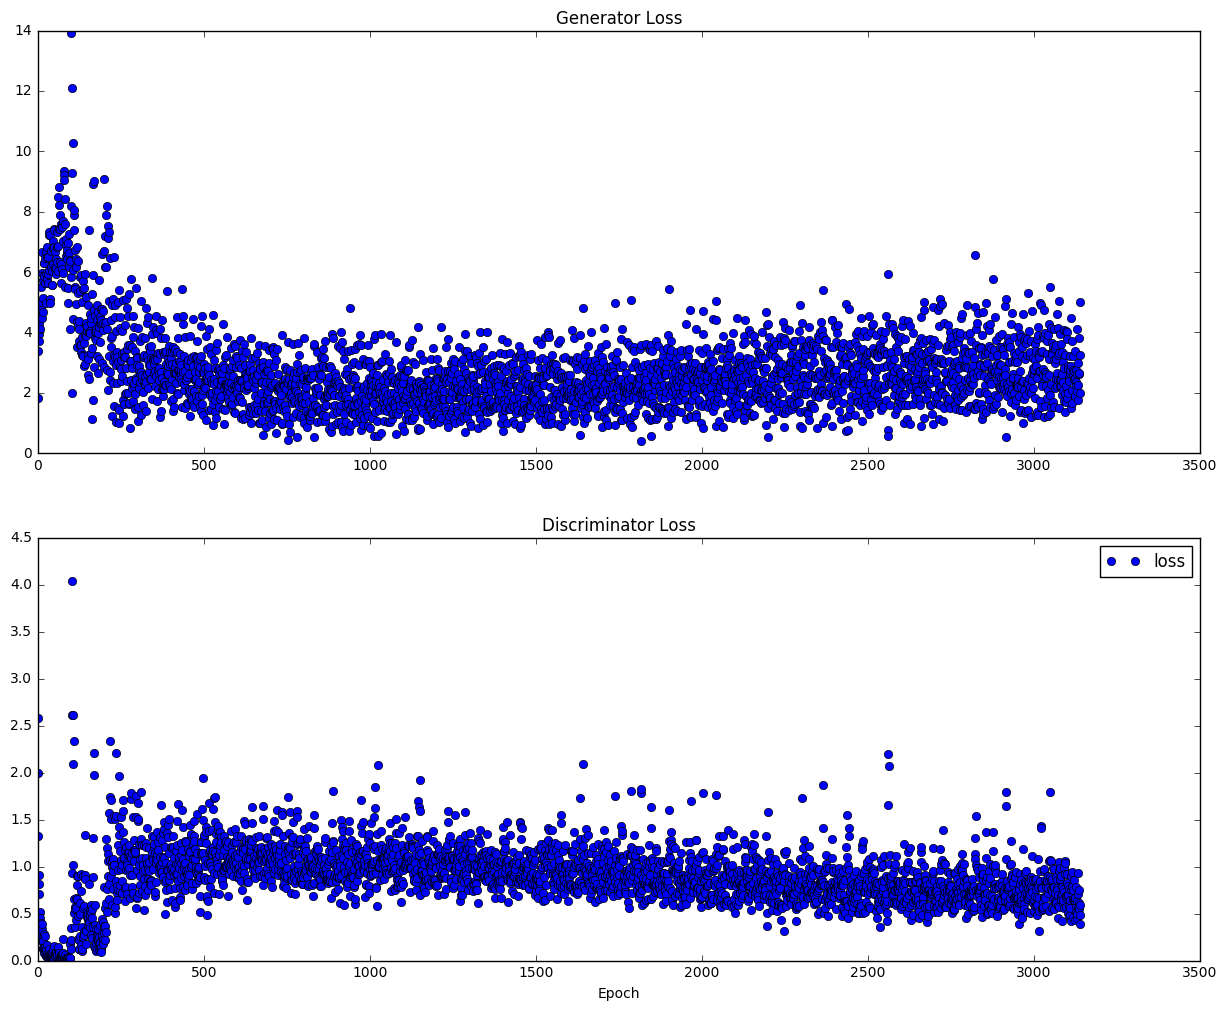

In [25]:
#imports for plotting graphs
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#plot training loss
plt.subplot(2, 1, 1)
plt.title('Generator Loss')
plt.plot(loss_g_history, 'o', label='loss')

#plot training loss
plt.subplot(2, 1, 2)
plt.title('Discriminator Loss')
plt.plot(loss_d_history, 'o', label='loss')


plt.legend(loc='upper right')
plt.gcf().set_size_inches(15, 12)
plt.xlabel('Epoch')